In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('genre_filtered_movie.csv')
data

,Unnamed: 0,Unnamed: 0.1,movie_id,cast,summary_wiki,movie_name,info_json,N/A,Sci-Fi,Crime,...,History,Film-Noir,Mystery,Fantasy,Biography,Documentary,Sport,Action,Drama,Adventure
0,0,0,Birds of Prey: And the Fantabulous Emancipatio...,"[{'nm8698119': [' Paloma Rabinov']}, {'nm43992...",Harley Quinn narrates the events of her life l...,Birds of Prey: And the Fantabulous Emancipatio...,{'Title': 'Birds of Prey: And the Fantabulous ...,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,1,1,Sonic the Hedgehog,"[{'nm9961714': [' Melody Nosipho Niemann']}, {...",Sonic is an extraterrestrial blue hedgehog who...,Sonic the Hedgehog,"{'Title': 'Sonic the Hedgehog', 'Year': '2020'...",0,1,0,...,0,0,0,0,0,0,0,1,0,1
2,2,2,Vikings,"[{'nm1573253': [' Alexander Ludwig']}, {'nm540...",The series is inspired by the tales of the Nor...,Vikings,"{'Title': 'Vikings', 'Year': '2013–', 'Rated':...",0,0,0,...,1,0,0,0,0,0,0,1,1,1
3,3,3,Star Trek: Picard,"[{'nm0403335': [' Michelle Hurd']}, {'nm108505...",Many years have passed since Data's demise. Fo...,Star Trek: Picard,"{'Title': 'Star Trek: Picard', 'Year': '2020–'...",0,1,0,...,0,0,0,0,0,0,0,1,1,1
4,4,4,Fantasy Island,"[{'nm0740264': [' Michael Rooker']}, {'nm10666...",This article's plot summary may be too long or...,Fantasy Island,"{'Title': 'Fantasy Island', 'Year': '2020', 'R...",0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575,1663,1838,High Society,"[{'nm0526184': [' John Lund']}, {'nm0000038': ...",Successful jazz musician C.K. Dexter Haven (wi...,High Society,"{'Title': 'High Society', 'Year': '1956', 'Rat...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1576,1664,1839,Chi-Raq,"[{'nm1869008': [' Anya Engel-Adams']}, {'nm000...","In Chicago's Southside, as the events are narr...",Chi-Raq,"{'Title': 'Chi-Raq', 'Year': '2015', 'Rated': ...",0,0,1,...,0,0,0,0,0,0,0,0,1,0
1577,1665,1840,Om Shanti Om,"[{'nm0082848': [' Bindu']}, {'nm2061852': [' A...","In 1977 , Om Prakash Makhija, a junior artist ...",Om Shanti Om,"{'Title': 'Om Shanti Om', 'Year': '2007', 'Rat...",0,0,0,...,0,0,0,0,0,0,0,1,1,0
1578,1667,1842,Teletubbies,"[{'nm0799619': [' John Simmit']}, {'nm0266623'...","The programme takes place in a grassy, floral ...",Teletubbies,"{'Title': 'Teletubbies', 'Year': '1997–2001', ...",0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [3]:
data['summary_wiki']

0       Harley Quinn narrates the events of her life l...
1       Sonic is an extraterrestrial blue hedgehog who...
2       The series is inspired by the tales of the Nor...
3       Many years have passed since Data's demise. Fo...
4       This article's plot summary may be too long or...
                              ...                        
1575    Successful jazz musician C.K. Dexter Haven (wi...
1576    In Chicago's Southside, as the events are narr...
1577    In 1977 , Om Prakash Makhija, a junior artist ...
1578    The programme takes place in a grassy, floral ...
1579    Chadwick Gates (Elvis Presley) has just gotten...
Name: summary_wiki, Length: 1580, dtype: object

In [4]:
nan_items = []
for i,d in data.iterrows():
    if type(d['summary_wiki'])!= str:
        nan_items.append(i)
        print(i)

362
939
1033


In [5]:
data = data.drop(nan_items)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from nltk.tokenize import word_tokenize

nlp = spacy.load('en_core_web_sm')
stop_words = stopwords.words("english")

#filter out names through nerc
def remove_names(text):
    document = nlp(text)
    ents = [e.text for e in document.ents if e.label_ != 'PERSON']
    return " ".join([item.text for item in document if item.text not in ents])

data['summary_no_names'] = data['summary_wiki'].apply(lambda x: remove_names(x))

def tokenize(content):
    letters_only = re.sub("[^a-zA-Z]",
                      " ",         
                      content )
    lower_case = letters_only.lower()
    tokens = word_tokenize(lower_case)
    words = [w for w in tokens if not w in stop_words]
    stems = [stemmer.lemmatize(word) for word in words]
    return(stems)

#create dictionary and incorporating 1 to n-gram  -> change to tf-idf
stemmer = WordNetLemmatizer()
vectorizer = CountVectorizer(ngram_range = (1,2),
                             lowercase = True,
                             tokenizer=tokenize,
                             preprocessor = None,
                             max_features=5000)

tfidf_vect = TfidfVectorizer(analyzer = 'word',tokenizer = tokenize, lowercase = True)#, #ngram_range=(1, 2),
#                                    lowercase=True, tokenizer=tokenize,
#                                    preprocessor=None, max_features=10000)


#bag of words
bow = vectorizer.fit_transform(data['summary_no_names'])

# vectorizer.vocabulary_
tfidf = tfidf_vect.fit_transform(data['summary_no_names'])

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

nb_topics = 10
lda = LatentDirichletAllocation(n_components=nb_topics, max_iter=20,
                                learning_method='batch')
document_topics = lda.fit_transform(bow)
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vectorizer.get_feature_names())

def print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        these_topics = topics[i: i + topics_per_chunk]
        len_this_chunk = len(these_topics)
        words = []
        for i in range(n_words):
            try:
                words.append(feature_names[sorting[these_topics, i]])
            except:
                pass

    #setting up word dictionary for comparison
    word_dict = {}
    for i in topics:
        word_dict.update({i : [word[i] for word in words]})
    
    return word_dict

lda_topics = print_topics(topics=range(nb_topics), feature_names=feature_names, sorting=sorting, topics_per_chunk=nb_topics, n_words=15)

for i in range(nb_topics):
    print(i,': ' ,lda_topics[i], '\n')

0 :  ['war', 'soldier', 'army', 'men', 'order', 'attack', 'force', 'george', 'officer', 'killed', 'battle', 'take', 'camp', 'kill', 'general'] 

1 :  ['team', 'crew', 'ship', 'max', 'group', 'force', 'escape', 'world', 'new', 'time', 'attack', 'attempt', 'mission', 'year', 'kill'] 

2 :  ['john', 'kill', 'find', 'escape', 'group', 'take', 'ship', 'family', 'return', 'death', 'attempt', 'killed', 'father', 'son', 'island'] 

3 :  ['family', 'new', 'life', 'friend', 'love', 'tell', 'take', 'father', 'home', 'child', 'get', 'show', 'go', 'later', 'year'] 

4 :  ['police', 'kill', 'money', 'car', 'joe', 'killed', 'escape', 'drug', 'harry', 'death', 'officer', 'find', 'murder', 'agent', 'detective'] 

5 :  ['find', 'house', 'go', 'home', 'room', 'mother', 'tell', 'sam', 'see', 'man', 'car', 'take', 'back', 'woman', 'later'] 

6 :  ['king', 'return', 'edward', 'castle', 'love', 'alice', 'queen', 'find', 'vampire', 'witch', 'father', 'logan', 'prince', 'take', 'kill'] 

7 :  ['bill', 'mike', 

In [8]:
lda.components_[0].sum()

36261.61741646062

In [9]:
data['clusters'] = np.argmax(document_topics, axis=1)

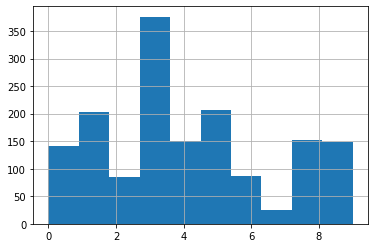

In [10]:
data['clusters'].hist()

In [20]:
from wordcloud import WordCloud
def topic_word_cloud(lda_model,feature_names, topic):
    
    word_matrix = lda_model.components_[topic]
    word_dict = dict(zip(feature_names, word_matrix))
    wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(word_dict)
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return wc

0 ------------------------------


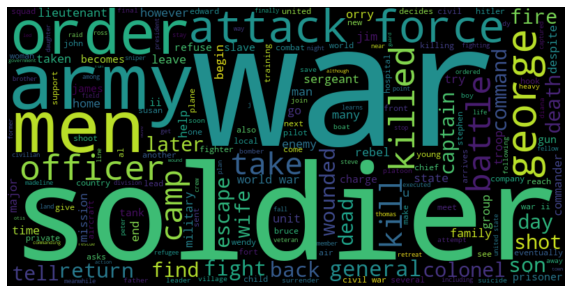

1 ------------------------------


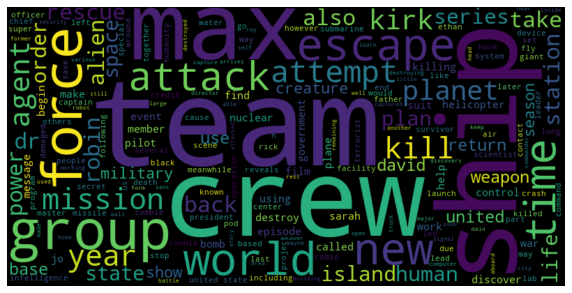

2 ------------------------------


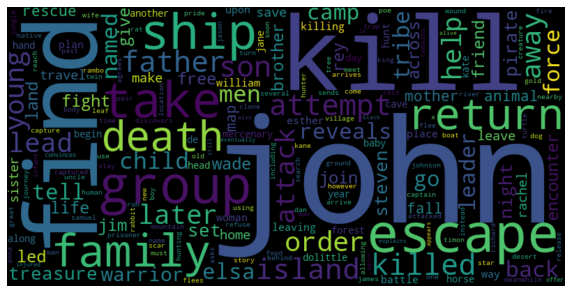

3 ------------------------------


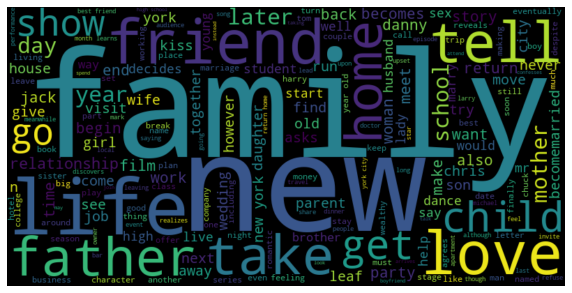

4 ------------------------------


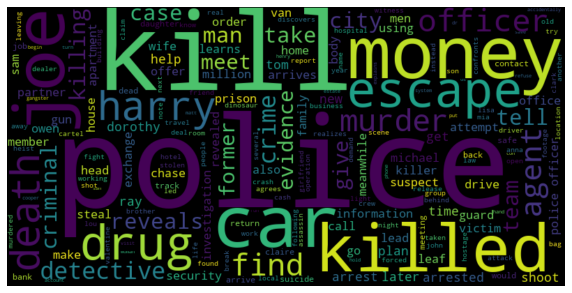

5 ------------------------------


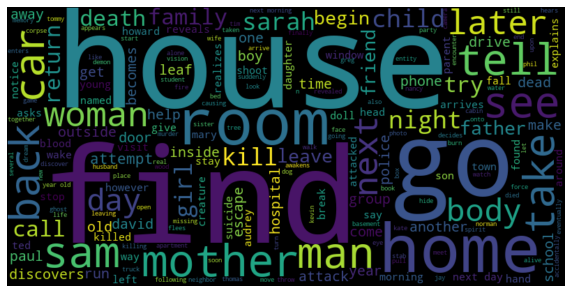

6 ------------------------------


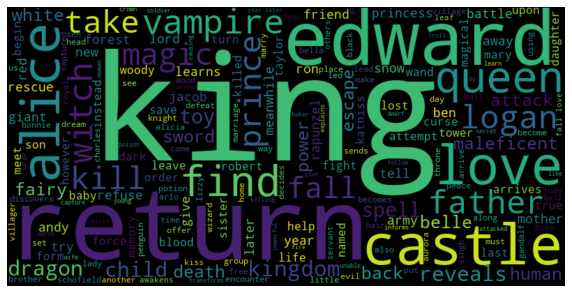

7 ------------------------------


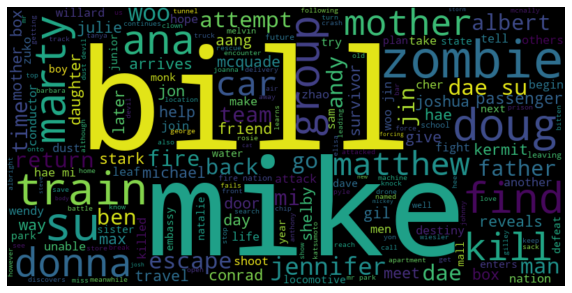

8 ------------------------------


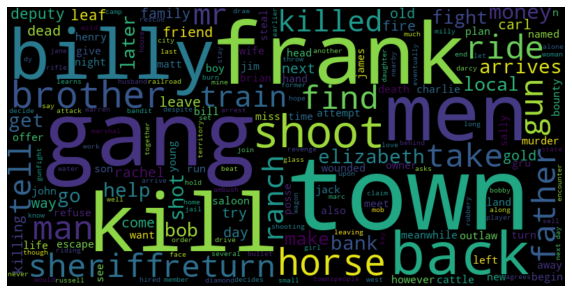

9 ------------------------------


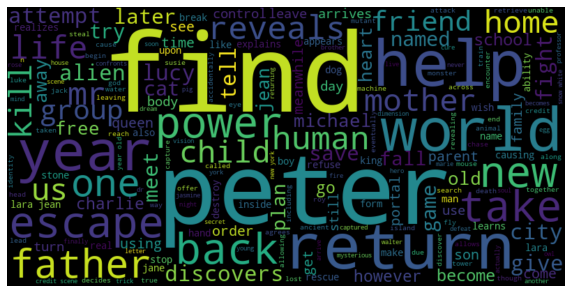

In [23]:
for i in range(nb_topics):
    print(i, '------------------------------')
    topic_word_cloud(lda, feature_names, i)


In [ ]:
vectorizer.transform(['fortune of crime'])

In [ ]:
data['summary_no_names'][0]

In [ ]:
def get_list_of_actors_clustering(lda_model, document_topics, word_vectorizer, text):
    feature_vector = word_vectorizer.transform(text)
    topic_distribution = lda_model.transform(feature_vector)
    